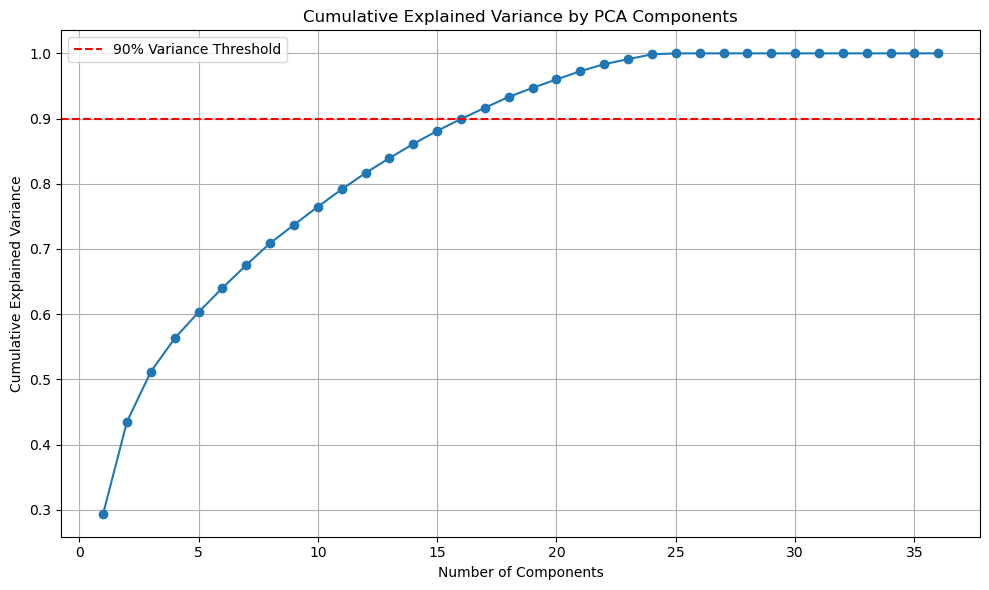


Top 5 features for PC1:
OnlineBackup_No internet service        0.28843
TechSupport_No internet service         0.28843
DeviceProtection_No internet service    0.28843
OnlineSecurity_No internet service      0.28843
InternetService_No                      0.28843
Name: PC1, dtype: float64

Top 5 features for PC2:
ContractLengthMonths    0.388421
Tenure                  0.362644
Contract_Two year       0.328215
ContractLifecycle       0.300708
TotalCharges            0.282741
Name: PC2, dtype: float64

Top 5 features for PC3:
PhoneService                      0.520025
MultipleLines_No phone service    0.520025
InternetService_Fiber optic       0.338629
MultipleLines_Yes                 0.299147
MonthlyCharges                    0.234813
Name: PC3, dtype: float64

Explained variance by each principal component:
  Principal Component  Explained Variance Ratio  Cumulative Variance
0                 PC1                  0.293878             0.293878
1                 PC2                  0

In [1]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('/Users/santiagoluque/churn_bcgx/data')
df = pd.read_csv('customers_processed.csv')

# Step 1: Load data
df = pd.read_csv('customers_processed.csv')

# Step 2: Handle TotalCharges (ensure it's numeric and drop rows with NaNs)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna()

# Step 3: Separate target and drop identifiers
y = df['Churn']
df = df.drop(columns=['CustomerId', 'Churn'])

# Step 4: Encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Step 5: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Step 6: Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Step 7: Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Step 8: Plot explained variance
plt.figure(figsize=(10,6))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Loadings (contributions of original features to each PC)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=df_encoded.columns
)

# Step 10: Top contributing features per PC
top_n = 5
for i in range(3):
    print(f"\nTop {top_n} features for PC{i+1}:")
    print(loadings[f'PC{i+1}'].abs().sort_values(ascending=False).head(top_n))

# Step 11: Explained variance summary
explained_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance Ratio': explained_variance,
    'Cumulative Variance': cumulative_variance
})
print("\nExplained variance by each principal component:")
print(explained_df.head(10))

# Step 12: Use top k components to explain ~90% of the variance
k = (cumulative_variance < 0.90).sum() + 1
X_reduced = X_pca[:, :k]

# Step 13: Train/test split and classification
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

print(f"\n✅ Logistic Regression Accuracy with Top {k} PCA Components: {accuracy:.4f}")


In [2]:
# Get the logistic regression coefficients
coefficients = clf.coef_[0]  # clf is your LogisticRegression model

# Name each principal component
components = [f'PC{i+1}' for i in range(k)]

# Create a DataFrame with PC names and their corresponding coefficients
coef_df = pd.DataFrame({
    'Principal Component': components,
    'Logistic Coefficient': coefficients
})

# View the DataFrame
print(coef_df)


   Principal Component  Logistic Coefficient
0                  PC1             -0.187250
1                  PC2             -0.684373
2                  PC3             -0.218537
3                  PC4             -0.013073
4                  PC5              0.178186
5                  PC6              0.038914
6                  PC7              0.024098
7                  PC8             -0.161192
8                  PC9              0.082720
9                 PC10              0.300843
10                PC11              0.098520
11                PC12              0.196231
12                PC13             -0.040809
13                PC14             -0.058980
14                PC15             -0.123310
15                PC16             -0.067848
16                PC17              0.049457


In [3]:
# Create the loadings matrix: how each original feature contributes to each PC
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=df_encoded.columns
)

# Set how many top features you want to inspect
top_n = 5

# Loop over the first k components and print top contributing features
for i in range(k):
    pc_name = f'PC{i+1}'
    print(f"\nTop {top_n} features contributing to {pc_name}:")
    top_features = loadings[pc_name].abs().sort_values(ascending=False).head(top_n)
    for feature, loading in top_features.items():
        actual_loading = loadings[pc_name][feature]
        print(f"  {feature}: loading = {actual_loading:.4f}")


Top 5 features contributing to PC1:
  OnlineBackup_No internet service: loading = 0.2884
  TechSupport_No internet service: loading = 0.2884
  DeviceProtection_No internet service: loading = 0.2884
  OnlineSecurity_No internet service: loading = 0.2884
  InternetService_No: loading = 0.2884

Top 5 features contributing to PC2:
  ContractLengthMonths: loading = 0.3884
  Tenure: loading = 0.3626
  Contract_Two year: loading = 0.3282
  ContractLifecycle: loading = 0.3007
  TotalCharges: loading = 0.2827

Top 5 features contributing to PC3:
  PhoneService: loading = -0.5200
  MultipleLines_No phone service: loading = 0.5200
  InternetService_Fiber optic: loading = -0.3386
  MultipleLines_Yes: loading = -0.2991
  MonthlyCharges: loading = -0.2348

Top 5 features contributing to PC4:
  ChangedPlanPositive_Yes: loading = 0.7098
  ChangedPlanNegative_Yes: loading = -0.6998
  PaymentMethod_Mailed check: loading = -0.0305
  PaymentMethod_Credit card (automatic): loading = 0.0272
  Dependents: l